# Adding external variables to the SARIMA model
* Modeling non-stationary time series - SARIMA
* Past values of the time series were used as predictors for future values

However, it is possible that external variables also have an impact on our time series and can therefore be good predictors of future values. This brings us to the **SARIMAX** model. The addition of the `X` term denotes `exogenous variables`.

**Note**: the term `exogenous` is used to describe predictors or input variables, while `endogenou`s is used to define the target variable; what we are trying to predict. With the SARIMAX model, we can now consider external variables, or exogenous 
variables, to forecast a time series.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

C:\Users\JK\anaconda3\envs\cuda90\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JK\anaconda3\envs\cuda90\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\JK\anaconda3\envs\cuda90\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## Defining SARIMAX model
we can express the present value yt simply as a $SARIMA (p,w,q)(P,W,Q)_m$ model to which we add any number of exogenous variables Xt as:

$y_t \rightarrow SARIMA (p,w,q)(P,W,Q)_m + \sum{\beta_i X_t^i}$

Note that in `SARIMAX`, the exogenous variables are continuous and not categorical. This makes sense since a linear regression is performed on the exogenous variables, and a linear regression cannot be applied on categorical variables. A model with no seasonality, but exogenous variables can be denoted as an `ARIMAX` model. With no seasonality or exogenous variables, it becomes an `ARIMA` model. 

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [6]:
macro_econ_data.columns

Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object')

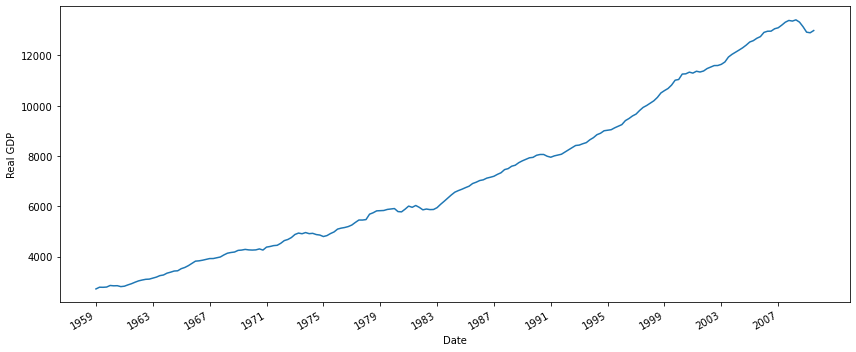

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

##  the clear positive trend over the years with no cyclical pattern, i.e. seasonality is not present in the series.

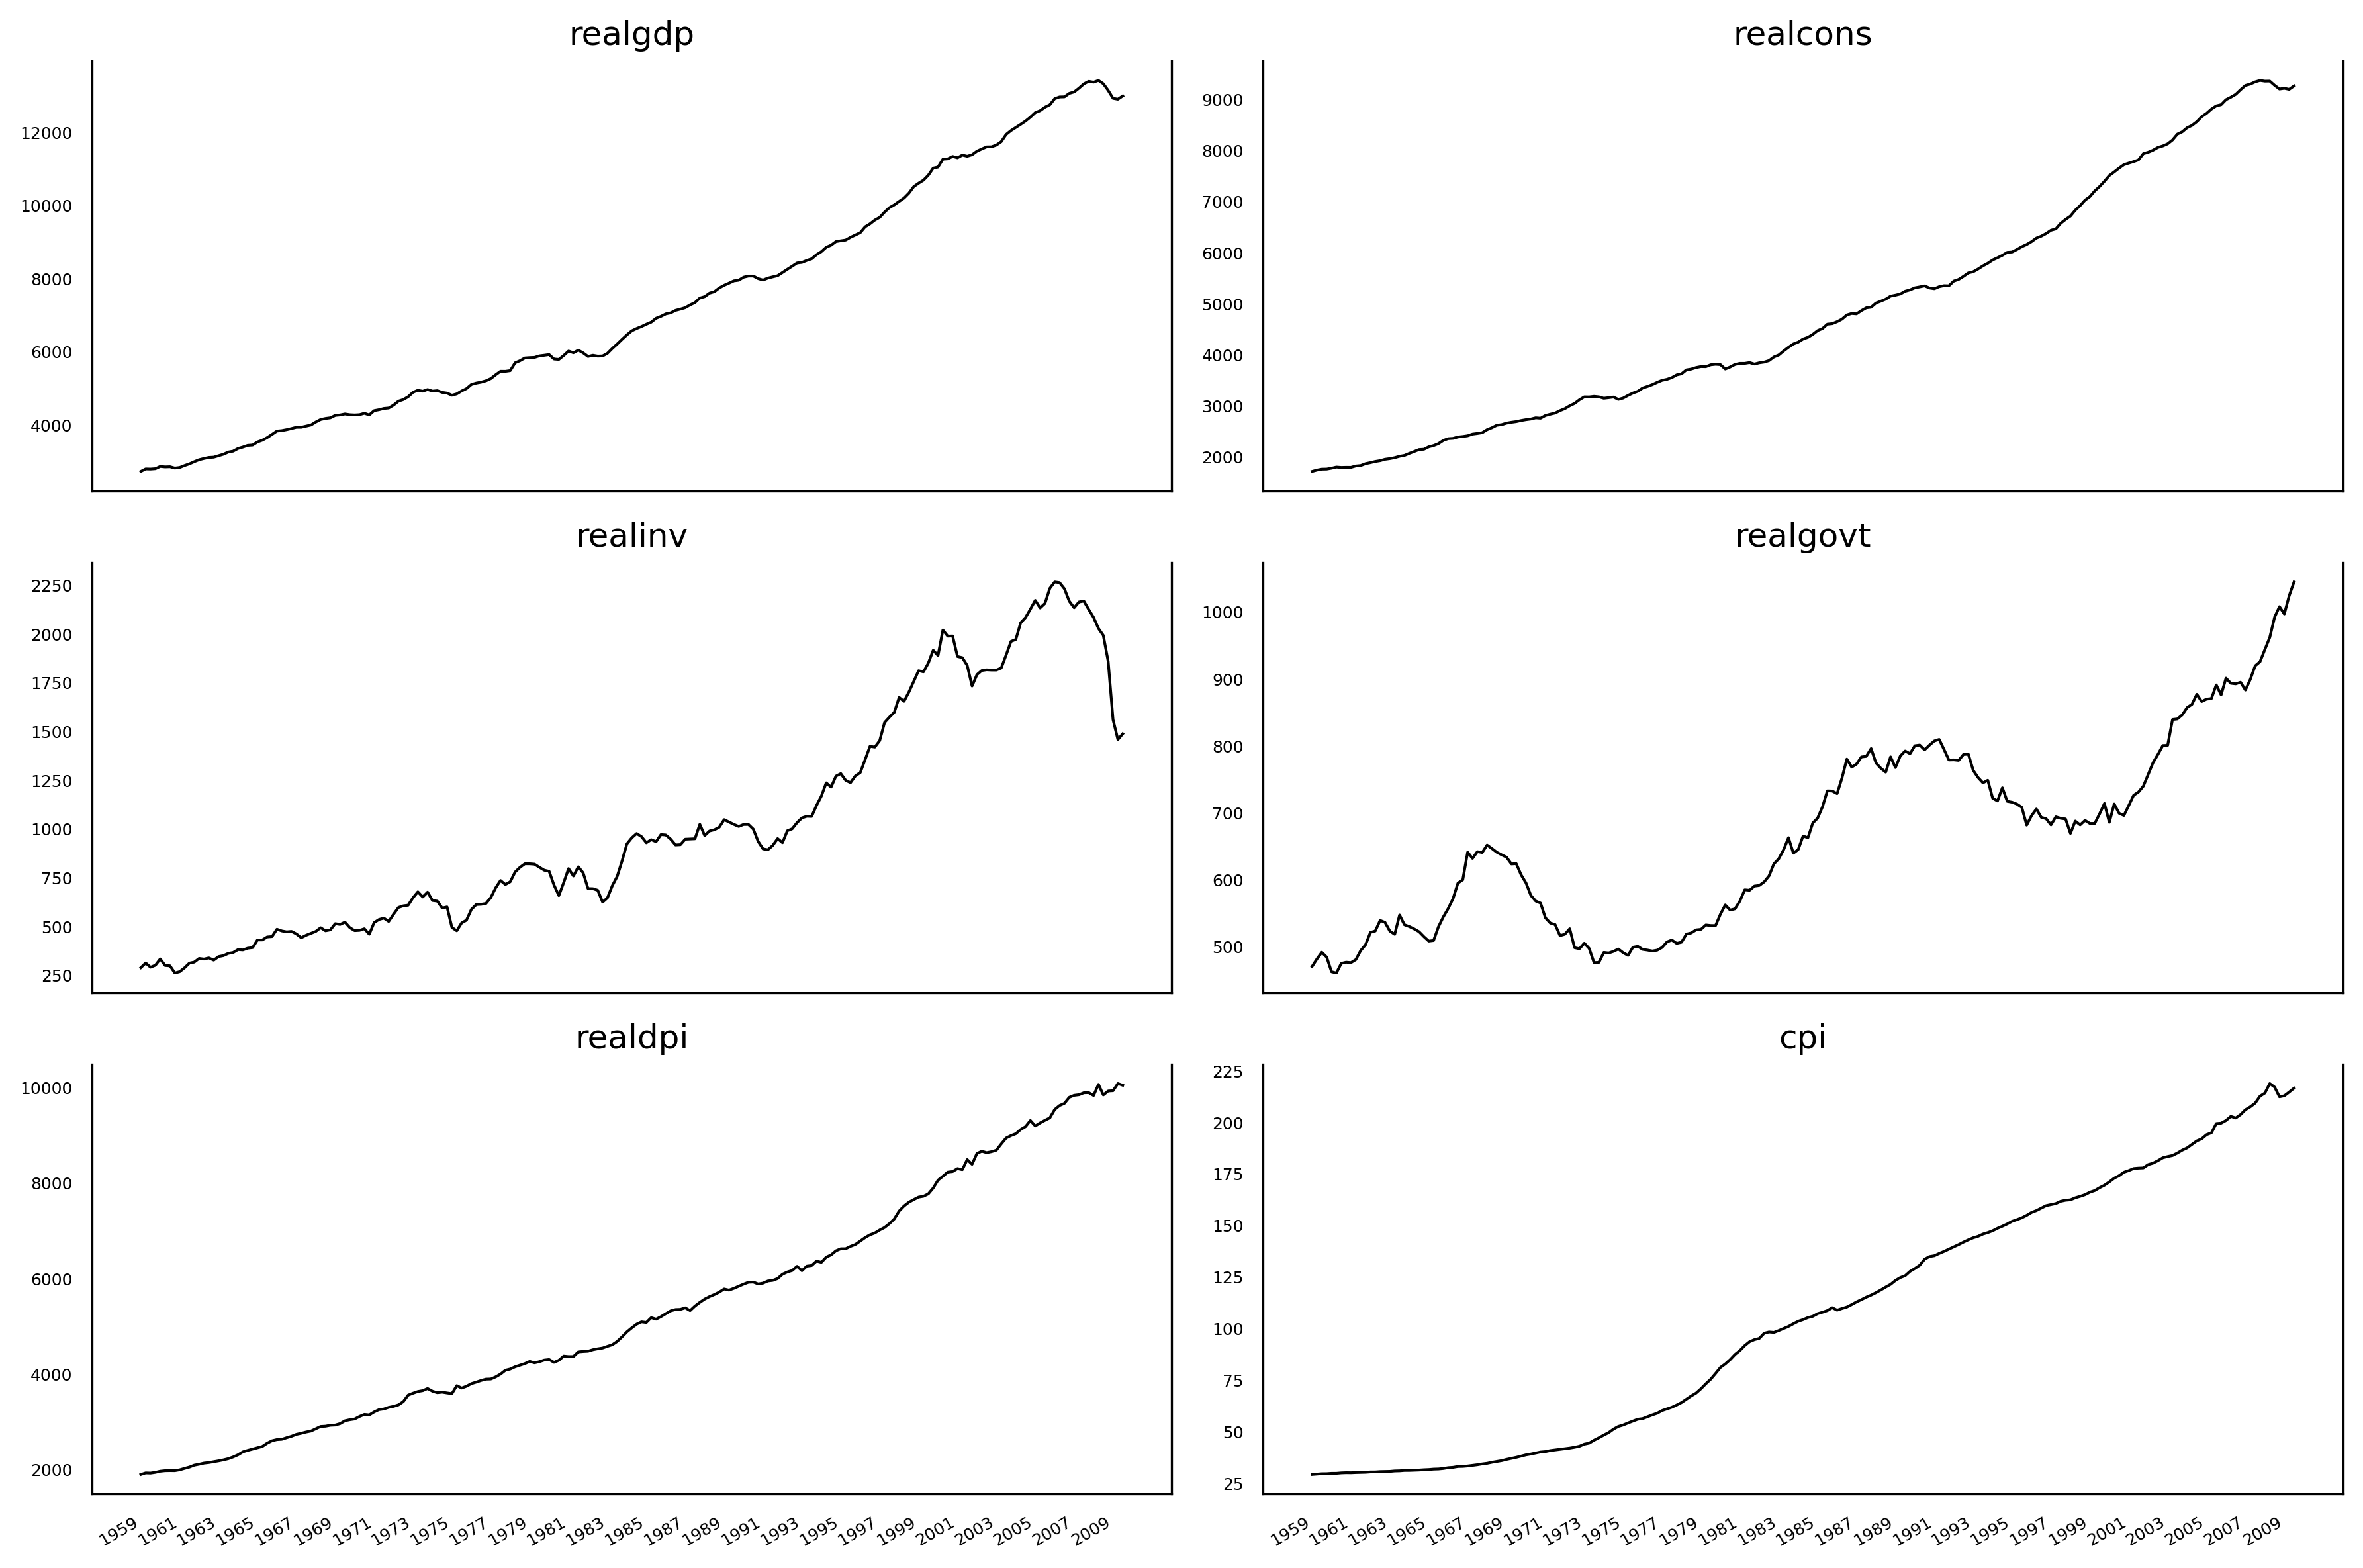

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

We notice that `realgdp`, `realcons`, `realdpi` and `cpi` all have a similar shape, which means that `realcons`, `realdpi` and `cpi` are potentially good predictors. On the other hand, realgovt has peaks and troughs that do not appear in realgdp, so we can hypothesize that `realgovt` is a weaker predictor.

The **SARIMAX** model will automatically find significant and non-significant predictors from the list of exogenous variables.

In [11]:
target = macro_econ_data['realgdp']
exog   = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [12]:
## Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0])) # Retrieve the ADF statistic
    print('p - value: {}'.format(result[1]))      # Retrieve the p-value
    if result[1] <= 0.05:
        print("strong evidence against the H0, reject the H0. Data has no unit root and is stationary")
    else:
        print("weak evidence against H0, time series has a unit root, indicating it is Non-stationary ")
    
    return result

ADF_result = adf_test(target)

ADF Statistics: 1.7504627967647128
p - value: 0.9982455372335032
weak evidence against H0, time series has a unit root, indicating it is Non-stationary 


In [14]:
target_diff = np.diff(target, n=1) # Series is now differenced once
ADF_result  = adf_test(target_diff)

ADF Statistics: -6.305695561658106
p - value: 3.327882187668224e-08
strong evidence against the H0, reject the H0. Data has no unit root and is stationary


In [15]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],
                     order_list: list, w: int, W: int, m: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], w, order[1]),
                seasonal_order=(order[2], W, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
p = range(0, 4, 1)
q = range(0, 4, 1) 
P = [0]  ## Set P and Q to 0, since we are working with an ARIMA(p,w,q) model
Q = [0] 
w = 1    ## number of times the series was differenced to become stationary
W = 0    ## Set W to 0 since we are working with an ARIMA(p,w,q) model
m = 4    ## frequency for seasonal pattern

parameters      = product(p, q, P, Q)
parameters_list = list(parameters)
target_train    = target[:200]
exog_train      = exog[:200]
result_df       = optimize_SARIMAX(target_train, exog_train, parameters_list, w, W, m)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824206
1,"(2, 2, 0, 0)",1745.508400
2,"(1, 2, 0, 0)",1750.458999
3,"(2, 1, 0, 0)",1751.227228
4,"(1, 3, 0, 0)",1751.395404
5,"(3, 1, 0, 0)",1752.892961
6,"(1, 1, 0, 0)",1753.810679
7,"(2, 3, 0, 0)",1754.439522
8,"(3, 2, 0, 0)",1755.152468
9,"(3, 0, 0, 0)",1757.252070


In [18]:
best_model     = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Tue, 25 Oct 2022   AIC                           1742.824
Time:                        16:50:29   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9707      0.045     21.517      0.000       0.882       1.059
realinv        1.0132      0.033     30.704      0.000       0.949       1.078
realgovt       0.7281      0.127      5.728      0.0

We can see that the `exogenous variables` were assigned coefficients. We can also see their `p-value` under the column P>|z|. Note that all `p-values` for our exogenous variables are less than 0.05, but that of `realdpi`. **This means that this variable is not significant in predicting the target**. Still, we can keep it inside the model, since its coefficient is 0.0091, meaning that its contribution is close to `Null`. 

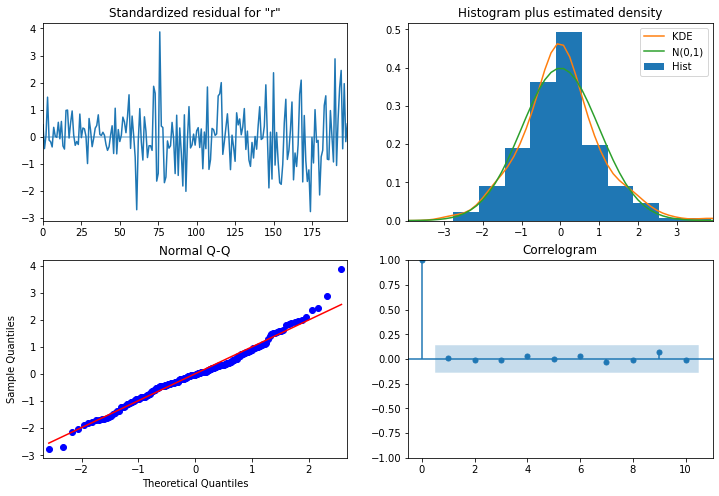

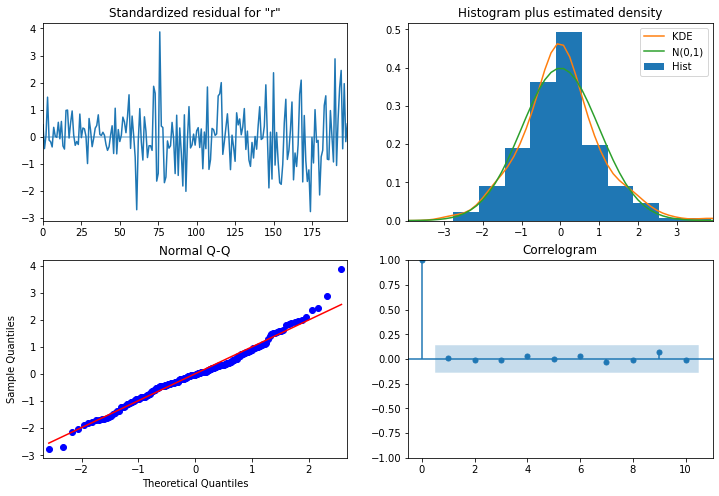

In [19]:
best_model_fit.plot_diagnostics(figsize=(12,8))

On the `top left` plot, the residuals have no trend and a fairly constant variance over time, just like white noise. On the `top right` plot, the distribution of residuals is very close to a normal distribution. This is further supported by the Q-Q plot on the `bottom left` that shows a fairly straight line that lies on y = x. On the `bottom right` plot, the correlogram shows no significant coefficients after lag 0, just like white noise. Therefore, from a graphical analysis, the residuals of this model resemble white noise.

In [20]:
residuals       = best_model_fit.resid 
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

## p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, meaning that
## the residuals are indeed uncorrelated, just like white noise.
## Therefore, the model passes all tests from the residuals analysis, and it can be used for forecasting. 

[0.76063422 0.90500953 0.97731198 0.86890423 0.93937615 0.9725777
 0.98315145 0.99294869 0.99353495 0.9972839 ]


In [21]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], 
                       train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [22]:
target_train = target[:196]
target_test  = target[196:]
## The test set contains the values starting in 2008 to the 3rd quarter of 2009. There is a total of 7 values to predict

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064853
197,13415.266,13366.865,13373.511602
198,13324.600,13415.266,13378.810708
199,13141.920,13324.600,13327.763078
200,12925.410,13141.920,13133.244184
201,12901.504,12925.410,12887.101126
202,12990.341,12901.504,12873.795377


In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7027925092095011


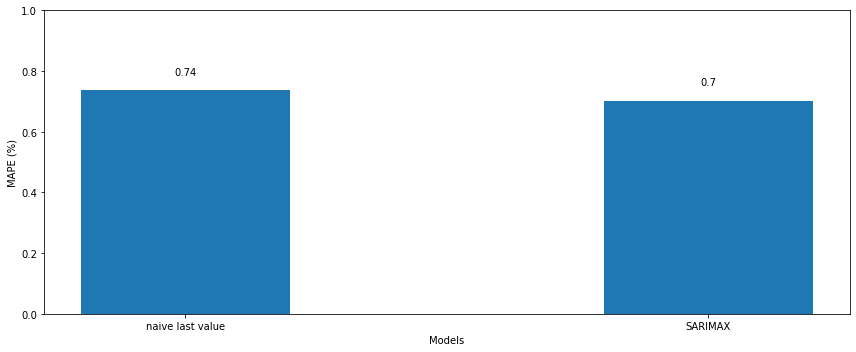

In [24]:
fig, ax = plt.subplots(figsize=(12,5))

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()